In [1]:
from utils.card_engine import Card_Game, Card_Env, random_agent

In [2]:
import math
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt

from itertools import count



# global game gym
env = Card_Env()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

# Replay Memory

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        # save a transition
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

# Q network

In [6]:
class DQN(nn.Module):

    # n_input: the current state
    #  (1x52)    +  (56x52)       +       (1x52): the current state
    #    ^hand       ^who plays each card  ^cards not seen yet
    #                       + cards played
    # n_output: probability of playing each card
    #   (1x52)
    def __init__(self, n_input, n_output):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_input, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_output)

    def forward(self, x):
        if x.dtype == torch.float32:
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
        else:
            x=x.to(torch.float32)
            x = F.relu(self.layer1(x))
            x = F.relu(self.layer2(x))
        return self.layer3(x)

# Training

### The network agent
Selects a move according to epsilon-greedy policy:
sometimes uses the model to select move, sometimes just select one randomally

In [9]:
# hyper-parameters
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000

# I am making batch_size small here so that we can test if this goes through in shorter time
BATCH_SIZE = 3
MEMORY_SIZE = 10000

# Learning rate of the optimizer
LR = 1e-4

# soft update rate
TAU = 0.005

# future discount
GAMMA = 1.0


state = env.game.get_network_input()

n_input = len(state)
n_actions = 52

policy_net = DQN(n_input, n_actions).to(device)
# use a target network to prevent oscillation or divergence
target_net = DQN(n_input, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())


optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(MEMORY_SIZE)

steps_done = 0

'''
Given the game state, select an action by the epsilon-greedy policy
'''
def select_action(game):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    # epsilon-greedy choice
        
    if sample > eps_threshold:
        with torch.no_grad():
            # return the index of the card with highest probability
            # predicted from the policy net
            print(policy_net(game.get_network_input().to(torch.float32).to(torch.device('cuda'))))
            return policy_net(game.get_network_input().to(torch.float32).to(torch.device('cuda'))).max(0).indices.view(1,1)
    else:
        # random select a legal action
        return torch.tensor([[game.sample_legal_move()]], device=device, dtype=torch.long) #changed from long



### Training loop

In [11]:
'''
A single step optimization of the model using Deep Q-Learning
1) samples a batch from memory, concatenates all the tensors into a single one
2) computes Q(s_t, a_t) and V(s_{t+1}) = max_a Q(s_{t+1}, a), where s_t --(a_t)--> s_{t+1}
3) computes the loss
4) updates the target network (which is computing V(s_{t+1})) at every step with soft update
'''
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # mask the non final states and find the corresponding next states
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = [s for s in batch.next_state if s is not None]
    if non_final_next_states == []:
        return
    non_final_next_states = torch.cat(non_final_next_states)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # compute Q(s_t, a)
    # for each state in the batch, find the value of the corresponding action
    state_action_values = policy_net(state_batch.to(torch.float)).gather(1, action_batch)
    # compute V(s_{t+1}) = max_a Q(s_{t+1}, a) for the next_states using the target_net
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # R + \gamma max_a Q(s', a)
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # compute the Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # back propagate
    optimizer.zero_grad()
    loss.backward()

    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


In [12]:
# the main training loop
step_counts = []

if device != torch.device('cpu'):
    num_episodes = 1000
else:
    num_episodes = 100

for i_episode in range(num_episodes):
    # initialize the game
    env.reset()
    game = env.game
    state = torch.tensor(game.get_network_input(), dtype=torch.long, device=device).unsqueeze(0)
    print('i_episode is', i_episode)

    for t in count():
        print('t is ', t)
        # play until the game ends
        if game.hands[game.current_player].sum(0) != 0:
            print(game.hands[game.current_player])
            action = select_action(game)
            print(action)
            observation, reward, terminated = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated
        else:
            terminated = True
            done = terminated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # store the transition in memory
        memory.push(state, action, next_state, reward)

        # move to the next state
        state = next_state

        # perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)


        if done:
            print(f'{i_episode}-th game ends in {t} steps')
            step_counts.append(t)
            break
        


C:\Users\evarv\AppData\Local\Temp\ipykernel_24888\3663926416.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(game.get_network_input(), dtype=torch.long, device=device).unsqueeze(0)
C:\Users\evarv\AppData\Local\Temp\ipykernel_24888\3663926416.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
C:\Users\evarv\Documents\Erdos\dql-trick-game\utils\card_engine.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  card = torch.nn.fu

i_episode is 0
t is  0
tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0])
tensor([[0]], device='cuda:0')
t is  1
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 0])
tensor([[11]], device='cuda:0')
t is  2
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 1])
tensor([[12]], device='cuda:0')
t is  3
tensor([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0])
tensor([[8]], device='cuda:0')
t is  4
tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0

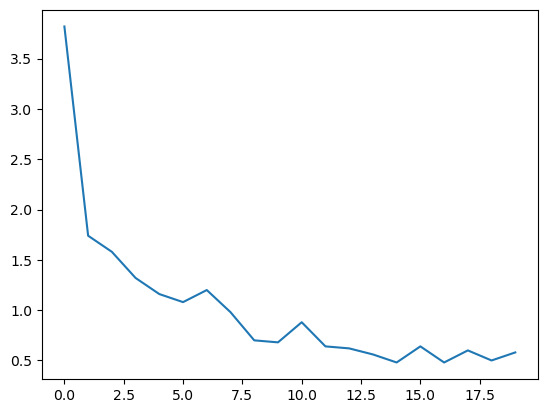

In [13]:
x = torch.tensor(step_counts, dtype=float).reshape(20, int(len(step_counts) / 20)).mean(1).numpy()
plt.plot(x)